In [1]:
import pandas as pd
pd.options.mode.chained_assignment=None
import numpy as np
from numpy.linalg import inv
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import NullFormatter
from matplotlib.collections import LineCollection
import matplotlib.transforms
import matplotlib.path
import seaborn as sns
sns.set_theme(style="white")
from scipy.ndimage import gaussian_filter
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.stats import pearsonr, kstwobign, linregress, gaussian_kde
from scipy.spatial.distance import mahalanobis
import time
import networkx as nx
import random
from tqdm import tqdm
from tabulate import tabulate

# Polarization across demographic groups

Load preprocessed dataset and embedded opinions of respondents.

In [2]:
dfsCombined = pd.read_csv('../csvfiles/combineddata.csv')
dfs2d = pd.read_csv('../csvfiles/embeddingISOMAP.csv')

In [3]:
yearsSubset = (1992, 2000, 2008, 2016, 2020)
numRespondents = [2485, 1807, 2322, 2500, 2500]
num = 0
dataframesWithAttributes = list()
for i in range(len(numRespondents)):
    dataframesWithAttributes.append(dfsCombined.iloc[num:num+numRespondents[i]].copy())
    num += numRespondents[i]

points2d = dfs2d.to_numpy()

We store the respondents' two-dimensional coordinates in a list according to the ANES edition and the demographic group of the specific attribute.

In [4]:
def differByAttribute(data, points2d, attribute):
    """ Get all the respondents' locations for every group in an attribute

    Parameters:
    data -- list of dataframes containing all respondents
    points2d -- 2d coordinates of all respondents
    attribute -- attribute under study
    """
    
    separators = list()
    for i in range(len(yearsSubset)):
        separators.append(len(data[i]))
    separators = [0] + separators
    cumulativeSeparators = list(np.cumsum(separators))

    points2dByYear = list()
    for i in range(len(yearsSubset)):
        points2dByYear.append(points2d[cumulativeSeparators[i]:cumulativeSeparators[i+1]])

    dens_perCategory = list()
    for cat in range(len(points2dByYear)):
        categInYear = list(data[cat][attribute])
        separator = data[0].columns.get_loc('party')
        indicators = data[0].columns[separator:]
        axx = {x:[] for x in data[0][indicators[indicators.get_loc(attribute)]]}
        for j in range(len(points2dByYear[cat])):
            for key in axx:
                if categInYear[j] == key:
                    axx[key].append(points2dByYear[cat][j])
        dens_perCategory.append(axx)
        
    return dens_perCategory

In [5]:
dens_perParty     = differByAttribute(dataframesWithAttributes, points2d, attribute='party')
dens_perRace      = differByAttribute(dataframesWithAttributes, points2d, attribute='race')
dens_perGender    = differByAttribute(dataframesWithAttributes, points2d, attribute='gender')
dens_perAge       = differByAttribute(dataframesWithAttributes, points2d, attribute='age')
dens_perAffluence = differByAttribute(dataframesWithAttributes, points2d, attribute='affluence')
dens_perEducation = differByAttribute(dataframesWithAttributes, points2d, attribute='education')

We define three useful dictionaries.

In [6]:
attributesData = {
    'party': dens_perParty,
    'race': dens_perRace,
    'gender': dens_perGender,
    'age': dens_perAge,
    'affluence': dens_perAffluence,
    'education': dens_perEducation
}

subcats = {
    'party': ['Democrats', 'Republicans'],
    'race': ['Black', 'White'],
    'gender': ['Female', 'Male'],
    'age': ['17-34', '55+'],
    'affluence': ['Low-Income', 'High-Income'],
    'education': ['No-College', 'College']
}
attributes = list(subcats.keys())

dens_allGroup = dict()
for attr in attributes:
    for sub in np.array(list(attributesData[attr][0].keys())):
        subUsers = np.array([[0,0]])
        for i in range(len(yearsSubset)):
            subUsers = np.concatenate((subUsers, attributesData[attr][i][sub]), axis=0)
        subUsers = np.delete(subUsers, 0, axis=0)
        dens_allGroup[sub] = list(subUsers)

Density distributions of opposite groups in the ideological space (Figure 1).

/tmp/ipykernel_11353/2760880864.py:50: RuntimeWarning: invalid value encountered in divide
  hist = 2.*histDem / hist - 1.
/tmp/ipykernel_11353/2760880864.py:50: RuntimeWarning: invalid value encountered in divide
  hist = 2.*histDem / hist - 1.
/tmp/ipykernel_11353/2760880864.py:50: RuntimeWarning: invalid value encountered in divide
  hist = 2.*histDem / hist - 1.
/tmp/ipykernel_11353/2760880864.py:50: RuntimeWarning: invalid value encountered in divide
  hist = 2.*histDem / hist - 1.
/tmp/ipykernel_11353/2760880864.py:50: RuntimeWarning: invalid value encountered in divide
  hist = 2.*histDem / hist - 1.
/tmp/ipykernel_11353/2760880864.py:50: RuntimeWarning: invalid value encountered in divide
  hist = 2.*histDem / hist - 1.


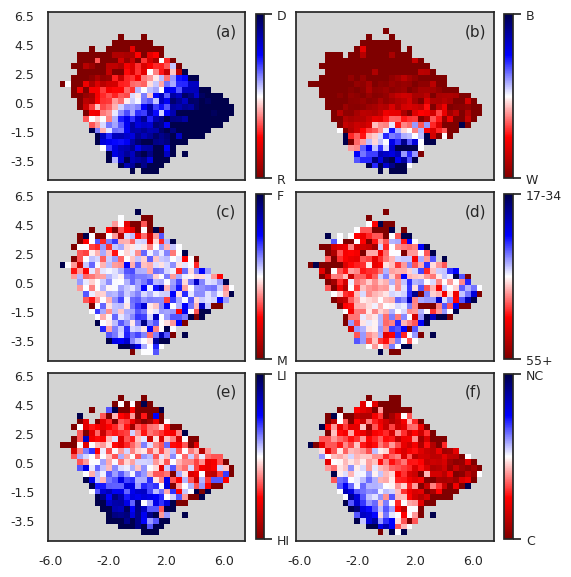

In [7]:
acr = [['D', 'R'], ['B', 'W'], ['F', 'M'], ['17-34', '55+'], ['LI', 'HI'], ['NC', 'C']]


# Finding bounding boxes
bbox = {
    'minX': np.min(points2d[:,0]),
    'maxX': np.max(points2d[:,0]),
    'minY': np.min(points2d[:,1]),
    'maxY': np.max(points2d[:,1])
}
plotRangeX = np.arange(
    math.floor(bbox['minX'] - 0.5),
    math.ceil(bbox['maxX'] + 1),
    0.4)
plotRangeY = np.arange(
    math.floor(bbox['minY'] - 0.5),
    math.ceil(bbox['maxY'] + 1),
    0.4)


label = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

fig, ax = plt.subplots(3,2, sharex = True, sharey = True, figsize=(6,10))
fig.subplots_adjust(hspace=-0.56)
fig.subplots_adjust(wspace=0.15)
# Customizing color map
cmap_reversed = matplotlib.colormaps['seismic'].reversed()
cmap_reversed.set_bad('lightgray', 1.)
    
for n,attr in enumerate(attributes):

    # Generating the plot
    fig2, ax2 = plt.subplots(figsize=(6,10))
    lsD = np.array(dens_allGroup[subcats[attr][0]])
    lsD = np.round(lsD, decimals=3)
    x = lsD[:,0]
    y = lsD[:,1]
    histDem, xbinsDem, ybinsDem, imDem = ax2.hist2d(x,y, bins=[plotRangeX,plotRangeY], cmap='plasma')
    plt.close(fig=fig2)

    ls = np.array(dens_allGroup[subcats[attr][0]] + dens_allGroup[subcats[attr][1]])
    ls = np.round(ls, decimals=3)
    fig2, ax2 = plt.subplots(figsize=(6,10))

    x = ls[:,0]
    y = ls[:,1]

    hist, xbins, ybins, im = ax2.hist2d(x,y, bins=[plotRangeX,plotRangeY], cmap='plasma')
    plt.close(fig=fig2)
    hist = 2.*histDem / hist - 1.
    masked_array = np.ma.array (hist, mask=np.isnan(hist))

    ax[int(np.floor(n/2)), n % 2].text(28.5, 3.5, label[n], fontsize=11)
    im = ax[int(np.floor(n/2)), n % 2].imshow(np.flip(masked_array.T, axis=0), interpolation='nearest', 
                                              cmap=cmap_reversed)
    ax[int(np.floor(n/2)), n % 2].set_yticks([0, 5, 10, 15, 20, 25],
        labels=[str(6.5), str(4.5), str(2.5), str(0.5), str(-1.5), str(-3.5)], fontsize=9)
    ax[int(np.floor(n/2)), n % 2].set_xticks([0, 10, 20, 30],
        labels=[str(-6 + 0*0.4), str(-6 + 10*0.4), str(-6 + 20*0.4), str(-6 + 30*0.4)], fontsize=9)
    cbar = fig.colorbar(im, ax=ax[int(np.floor(n/2)), n % 2], ticks=[-1,1], fraction=0.038)
    cbar.ax.set_yticklabels([acr[n][1], acr[n][0]], fontsize=9)
#plt.savefig('respondents_density.pdf', bbox_inches="tight")

Gradient vectors computed from the respective opinion distributions (Figure 2).

In [8]:
def arrow_drawing(x, y, dx, dy, cmap, vmin, vmax, locmin, locmax, n, i, loc, lw=3):
    
    # Group labels
    ax.annotate(subcats[attr][0], xy=[x,y], xytext=[dx + loc[2*i][0], dy + loc[2*i][1]], fontsize=10)
    ax.annotate(subcats[attr][1], xy=[x,y], xytext=[-dx + loc[2*i+1][0], -dy + loc[2*i+1][1]], fontsize=10)
    
    # Blue-half arrow
    ini = np.linspace(x,dx,n)
    fin = np.linspace(y,dy,n)
    points = np.array([ini,fin]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    lc = LineCollection(segments, cmap='seismic', linewidth=lw, norm=plt.Normalize(vmin=vmin,vmax=vmax))
    lc.set_array(np.linspace(0,locmin,n))
    ax.add_collection(lc)
    
    # Triangle blue-head
    tricoords = [(0,-0.4),(0.5,0),(0,0.4),(0,-0.4)]
    angle = np.arctan2(dy-y, dx-x)
    rot = matplotlib.transforms.Affine2D().rotate(angle)
    tricoords2 = rot.transform(tricoords)
    tri = matplotlib.path.Path(tricoords2, closed=True)
    ax.scatter(dx, dy, c=locmin, s=(3*lw)**2, marker=tri, cmap=cmap, norm=plt.Normalize(vmin=vmin,vmax=vmax))
    
    # Red-half arrow
    ini = np.linspace(x,-dx,n)
    fin = np.linspace(y,-dy,n)
    points = np.array([ini,fin]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)
    lc = LineCollection(segments, cmap='seismic', linewidth=lw, norm=plt.Normalize(vmin=vmin,vmax=vmax))
    lc.set_array(np.linspace(0,locmax,n))
    ax.add_collection(lc)
    
    # Triangle red-head
    tricoords = [(0,-0.4),(0.5,0),(0,0.4),(0,-0.4)]
    angle = np.arctan2(-dy-y, -dx-x)
    rot = matplotlib.transforms.Affine2D().rotate(angle)
    tricoords2 = rot.transform(tricoords)
    tri = matplotlib.path.Path(tricoords2, closed=True)
    ax.scatter(-dx, -dy, c=locmax, s=(3*lw)**2, marker=tri, cmap=cmap, norm=plt.Normalize(vmin=vmin,vmax=vmax))

/tmp/ipykernel_11353/30991920.py:31: RuntimeWarning: invalid value encountered in divide
  hist = 2.*histDem / hist - 1.
/tmp/ipykernel_11353/30991920.py:80: RuntimeWarning: invalid value encountered in divide
  hist = 2.*histDem / hist - 1.


(np.float64(-19.48903920662402),
 np.float64(19.48903920662402),
 np.float64(-23.2013118819048),
 np.float64(23.2013118819048))

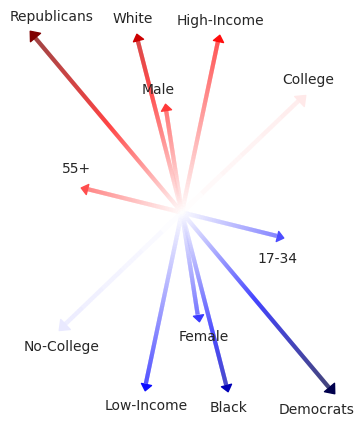

In [9]:
loc = [[-6.0, -3.2], [-3.0, 2.0], [-2.0, -3.2], [-3.0, 2.0], [-2.3, -3.2], [-3.0, 2.0],
       [-2.3, -3.2], [-3.0, 2.0], [-5.0, -3.2], [-5.0, 2.0], [-5.0, -3.2], [-2.0, 2.0]]

# Customizing color map
cmap = plt.get_cmap('seismic')
fig, ax = plt.subplots(figsize=(5,5))

# Generating histogram for party attribute
attr = 'party'
fig2, ax2 = plt.subplots(figsize=(5,5))
lsD = np.array(dens_allGroup[subcats[attr][0]])
lsD = gaussian_filter(lsD, sigma=0.5)
lsD = np.round(lsD, decimals=3)
x = lsD[:,0]
y = lsD[:,1]
histDem, xbinsDem, ybinsDem, imDem = ax2.hist2d(x,y, bins=[plotRangeX,plotRangeY], cmap='plasma')
plt.close(fig=fig2)

ls = np.array(dens_allGroup[subcats[attr][0]] + dens_allGroup[subcats[attr][1]])
ls = gaussian_filter(ls, sigma=0.5)
l = len(ls)
ls = np.round(ls, decimals=3)
fig2, ax2 = plt.subplots(figsize=(5,5))

x = ls[:,0]
y = ls[:,1]

hist, xbins, ybins, im = ax2.hist2d(x,y, bins=[plotRangeX,plotRangeY], cmap='plasma')
plt.close(fig=fig2)
cases = hist.T >= 10
hist = 2.*histDem / hist - 1.

# Computing gradient arrows
radiant = []
histGradient = hist.T
histGradient[np.isnan(histGradient)] = 0
yd, xd = np.gradient(histGradient)

locX = np.sum(xd[cases])
locY = np.sum(yd[cases])
radiant.append(np.arctan2(locY, locX))
ext = np.sqrt(locX**2 + locY**2)
n = 501
arrow_drawing(0., 0., locX, locY, cmap, -ext, ext, -ext, ext, n+1, 0, loc)

# Defining colormesh
sop = np.linspace(-ext, ext, n)
sopX = np.linspace(-abs(locX), abs(locX), n)
sopY = np.linspace(-abs(locY), abs(locY), n)
C = np.array([np.zeros(n)])
for i in sop:
    C = np.concatenate((C, [np.linspace((i + ext)/2., (i - ext)/2., n)]), axis=0)
C = np.delete(C, 0, axis=0)


# Remaining attributes
for k,attr in enumerate(attributes[1:]):
    
    # Generating histogram
    fig2, ax2 = plt.subplots(figsize=(15,12))
    lsD = np.array(dens_allGroup[subcats[attr][0]])
    lsD = gaussian_filter(lsD, sigma=0.5)
    lsD = np.round(lsD, decimals=3)
    x = lsD[:,0]
    y = lsD[:,1]
    histDem, xbinsDem, ybinsDem, imDem = ax2.hist2d(x,y, bins=[plotRangeX,plotRangeY], cmap='plasma')
    plt.close(fig=fig2)

    ls = np.array(dens_allGroup[subcats[attr][0]] + dens_allGroup[subcats[attr][1]])
    ls = gaussian_filter(ls, sigma=0.5)
    ls = np.round(ls, decimals=3)
    fig2, ax2 = plt.subplots(figsize=(5,5))

    x = ls[:,0]
    y = ls[:,1]

    hist, xbins, ybins, im = ax2.hist2d(x,y, bins=[plotRangeX,plotRangeY], cmap='plasma')
    plt.close(fig=fig2)
    cases = hist.T >= 10
    hist = 2.*histDem / hist - 1.

    # Computing gradient arrows
    histGradient = hist.T
    histGradient[np.isnan(histGradient)] = 0
    yd, xd = np.gradient(histGradient)
    locX = np.sum(xd[cases])
    locY = np.sum(yd[cases])
    radiant.append(np.arctan2(locY, locX))
    extAttr = np.sqrt(locX**2 + locY**2)*np.cos(radiant[-1] - radiant[0])
    arrow_drawing(0., 0., locX, locY, cmap, -ext, ext, -extAttr, extAttr, n+1, k+1, loc)

ax.autoscale_view()
ax.set_aspect(1.0)
ax.axis('off')
#plt.savefig('respondents_density_arrows.pdf', bbox_inches="tight")

## 2D Kolmogorov-Smirnov test

Code source: https://github.com/syrte/ndtest/

In [10]:
def ks2d2s(x1, y1, x2, y2, nboot=None, extra=False):
    ''' Two-dimensional Kolmogorov-Smirnov test on two samples.
    
    Parameters
    ----------
    x1, y1 : ndarray, shape (n1, )
        Data of sample 1.
    x2, y2 : ndarray, shape (n2, )
        Data of sample 2. Size of two samples can be different.
    nboot : None or int
        Number of bootstrap resample to estimate the p-value. A large number is expected.
        If None, an approximate analytic estimate will be used.
    extra: bool, optional
        If True, KS statistic is also returned. Default is False.
        
    Returns
    -------
    p : float
        Two-tailed p-value.
    D : float, optional
        KS statistic, returned if keyword `extra` is True.
        
    Notes
    -----
    This is the two-sided K-S test. Small p-values means that the two samples are significantly different. 
    Note that the p-value is only an approximation as the analytic distribution is unkonwn. The approximation
    is accurate enough when N > ~20 and p-value < ~0.20 or so. When p-value > 0.20, the value may not be accurate,
    but it certainly implies that the two samples are not significantly different. (cf. Press 2007)
    
    References
    ----------
    Peacock, J.A. 1983, Two-Dimensional Goodness-of-Fit Testing in Astronomy, MNRAS, 202, 615-627
    Fasano, G. and Franceschini, A. 1987, A Multidimensional Version of the Kolmogorov-Smirnov Test, MNRAS, 225, 155-170
    Press, W.H. et al. 2007, Numerical Recipes, section 14.8
    '''
    
    assert (len(x1) == len(y1)) and (len(x2) == len(y2))
    n1, n2 = len(x1), len(x2)
    D = avgmaxdist(x1, y1, x2, y2)

    if nboot is None:
        sqen = np.sqrt(n1 * n2 / (n1 + n2))
        r1 = pearsonr(x1, y1)[0]
        r2 = pearsonr(x2, y2)[0]
        r = np.sqrt(1 - 0.5 * (r1**2 + r2**2))
        d = D * sqen / (1 + r * (0.25 - 0.75 / sqen))
        p = kstwobign.sf(d)
    else:
        n = n1 + n2
        x = np.concatenate([x1, x2])
        y = np.concatenate([y1, y2])
        d = np.empty(nboot, 'f')
        for i in range(nboot):
            idx = np.random.choice(n, n, replace=True)
            ix1, ix2 = idx[:n1], idx[n1:]
            #ix1 = np.random.choice(n, n1, replace=True)
            #ix2 = np.random.choice(n, n2, replace=True)
            d[i] = avgmaxdist(x[ix1], y[ix1], x[ix2], y[ix2])
        p = np.sum(d > D).astype('f') / nboot
    if extra:
        return p, D
    else:
        return p


def avgmaxdist(x1, y1, x2, y2):
    D1 = maxdist(x1, y1, x2, y2)
    D2 = maxdist(x2, y2, x1, y1)
    return (D1 + D2) / 2


def maxdist(x1, y1, x2, y2):
    n1 = len(x1)
    D1 = np.empty((n1, 4))
    for i in range(n1):
        a1, b1, c1, d1 = quadct(x1[i], y1[i], x1, y1)
        a2, b2, c2, d2 = quadct(x1[i], y1[i], x2, y2)
        D1[i] = [a1 - a2, b1 - b2, c1 - c2, d1 - d2]

    # re-assign the point to maximize difference,
    # the discrepancy is significant for N < ~50
    D1[:, 0] -= 1 / n1

    dmin, dmax = -D1.min(), D1.max() + 1 / n1
    return max(dmin, dmax)


def quadct(x, y, xx, yy):
    n = len(xx)
    ix1, ix2 = xx <= x, yy <= y
    a = np.sum(ix1 & ix2) / n
    b = np.sum(ix1 & ~ix2) / n
    c = np.sum(~ix1 & ix2) / n
    d = 1 - a - b - c
    return a, b, c, d

KS distance between demographic groups of the most polarized attributes (Supplementary Figure 5).

In [11]:
attributesKS = ['party', 'race', 'affluence', 'education']
groupDic = dict()
for attr in attributesKS:
    for sub in subcats[attr]:
        subUsers = np.array([[0,0]])
        for k in range(len(yearsSubset)):
            subUsers = np.concatenate((subUsers, attributesData[attr][k][sub]), axis=0)
        subUsers = np.delete(subUsers, 0, axis=0)
        groupDic[sub] = subUsers


start = time.time()

groups = ['Democrats', 'Republicans', 'Black', 'White', 'Low-Income', 'High-Income', 'No-College', 'College']
groupSize = len(groups)
KSscore = np.zeros((groupSize,groupSize))
KSdic = dict()
for i in range(groupSize):
    for j in range(groupSize):
        group1 = groupDic[groups[i]]
        group2 = groupDic[groups[j]]
        x1, y1 = group1[:,0], group1[:,1]
        x2, y2 = group2[:,0], group2[:,1]
        p, D = ks2d2s(x1, y1, x2, y2, extra=True)
        KSscore[i,j] = D
    KSdic[groups[i]] = KSscore[i,:]
KSdata = pd.DataFrame(data=KSdic, index=groups)

end = time.time()

print(f'Execution time: {round(end - start, 2)} s')

Execution time: 30.4 s


[Text(0, 0.5, 'Democrats'),
 Text(0, 1.5, 'Republicans'),
 Text(0, 2.5, 'Black'),
 Text(0, 3.5, 'White'),
 Text(0, 4.5, 'Low-Income'),
 Text(0, 5.5, 'High-Income'),
 Text(0, 6.5, 'No-College'),
 Text(0, 7.5, 'College')]

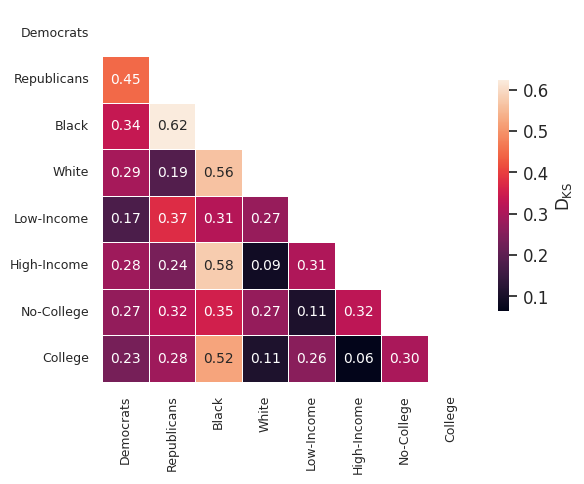

In [12]:
mask = np.triu(np.ones_like(KSscore, dtype=bool))
fig, ax = plt.subplots(figsize=(6,6))
heat = sns.heatmap(KSdata, mask=mask, annot=True, annot_kws={"size":10}, fmt=".2f", square=True, 
            linewidths=.5, cbar_kws={"shrink": .5, "label": r'$\mathregular{D_{KS}}$'})
cbar = heat.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
#plt.savefig('KSdistance_groups.pdf', bbox_inches="tight")

Minimum spanning tree as a function of the KS distance (Supplementary Figure 6).

In [13]:
start = time.time()

groups = ['Black', 'Democrats', 'Low-Income', 'No-College', 'College', 'High-Income', 'White', 'Republicans']
graphscore = np.zeros((groupSize,groupSize))
groupLabels = dict()
itemLabels = dict()
for i in range(groupSize):
    groupLabels[i] = groups[i]
    itemLabels[groups[i]] = i
    for j in range(i+1, groupSize):
        group1 = groupDic[groups[i]]
        group2 = groupDic[groups[j]]
        x1, y1 = group1[:,0], group1[:,1]
        x2, y2 = group2[:,0], group2[:,1]
        p, D = ks2d2s(x1, y1, x2, y2, extra=True)
        graphscore[i,j] = D

end = time.time()

print(f'Execution time: {round(end - start, 2)} s')

Execution time: 13.19 s


(np.float64(-0.48223415510056794),
 np.float64(0.30917945521999635),
 np.float64(-0.10139200629690992),
 np.float64(0.36819534446691027))

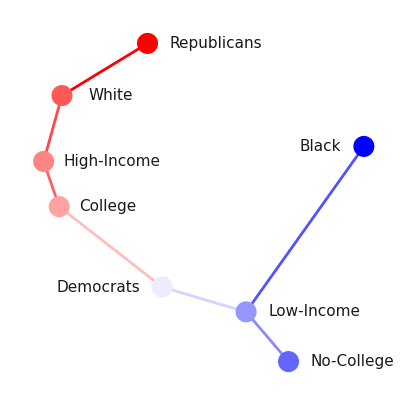

In [14]:
MST = minimum_spanning_tree(graphscore)
G = nx.from_numpy_array(MST)

# Positions
pos = dict()
sep = lambda ang: np.array([-np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))])
pos[itemLabels['Low-Income']] = np.array([0.,0.])
pos[itemLabels['Black']] = pos[itemLabels['Low-Income']] + np.array([-1,1])*sep(40)*G.edges[2,0]['weight']
pos[itemLabels['No-College']] = pos[itemLabels['Low-Income']] + np.array([-1,-1])*sep(35)*G.edges[2,3]['weight']
pos[itemLabels['Democrats']] = pos[itemLabels['Low-Income']] + sep(10)*G.edges[2,1]['weight']
pos[itemLabels['College']] = pos[itemLabels['Democrats']] + sep(25)*G.edges[1,4]['weight']
pos[itemLabels['High-Income']] = pos[itemLabels['College']] + sep(60)*G.edges[4,5]['weight']
pos[itemLabels['White']] = pos[itemLabels['High-Income']] + sep(115)*G.edges[5,6]['weight']
pos[itemLabels['Republicans']] = pos[itemLabels['White']] + sep(160)*G.edges[6,7]['weight']

# Node colors
colorIndex = np.empty(groupSize)
colorIndex[itemLabels['Black']] = 0
colorIndex[itemLabels['Low-Income']] = G.edges[2,0]['weight']
colorIndex[itemLabels['No-College']] = colorIndex[itemLabels['Low-Income']] - G.edges[2,3]['weight']
colorIndex[itemLabels['Democrats']] = colorIndex[itemLabels['Low-Income']] + G.edges[2,1]['weight']
colorIndex[itemLabels['College']] = colorIndex[itemLabels['Democrats']] + G.edges[1,4]['weight']
colorIndex[itemLabels['High-Income']] = colorIndex[itemLabels['College']] + G.edges[4,5]['weight']
colorIndex[itemLabels['White']] = colorIndex[itemLabels['High-Income']] + G.edges[5,6]['weight']
colorIndex[itemLabels['Republicans']] = colorIndex[itemLabels['White']] + G.edges[6,7]['weight']

# Edge colors
colorEdge = np.empty(groupSize - 1)
colorEdge[0] = colorIndex[itemLabels['Low-Income']]/2.
colorEdge[1] = (colorIndex[itemLabels['Low-Income']] + colorIndex[itemLabels['No-College']])/2.
colorEdge[2] = colorIndex[itemLabels['Low-Income']] + G.edges[2,1]['weight']/2.
colorEdge[3] = colorIndex[itemLabels['Democrats']] + G.edges[1,4]['weight']/2.
colorEdge[4] = colorIndex[itemLabels['College']] + G.edges[4,5]['weight']
colorEdge[5] = colorIndex[itemLabels['High-Income']] + G.edges[5,6]['weight']/2.
colorEdge[6] = colorIndex[itemLabels['White']] + G.edges[6,7]['weight']/2.

# Plot
posLabel = dict()
desp = [-0.09, -0.13, 0.14, 0.13, 0.10, 0.14, 0.10, 0.14]
for n,i in enumerate(groups):
    posLabel[itemLabels[i]] = pos[itemLabels[i]] + np.array([desp[n], 0])

fig, ax = plt.subplots(figsize=(5,5))
nx.draw_networkx_nodes(G, node_color=colorIndex, node_size=200, pos=pos, ax=ax, 
                       cmap=matplotlib.colormaps['bwr'])
nx.draw_networkx_edges(G, edgelist=[(itemLabels['Black'], itemLabels['Low-Income']), 
                                    (itemLabels['Low-Income'], itemLabels['No-College']), 
                                    (itemLabels['Low-Income'], itemLabels['Democrats']), 
                                    (itemLabels['Democrats'], itemLabels['College']), 
                                    (itemLabels['College'], itemLabels['High-Income']), 
                                    (itemLabels['High-Income'], itemLabels['White']), 
                                    (itemLabels['White'], itemLabels['Republicans'])], 
                       edge_color=colorEdge, width=2, pos=pos, ax=ax, 
                       edge_cmap=matplotlib.colormaps['bwr'], edge_vmin=0, edge_vmax=colorEdge[-1])
nx.draw_networkx_labels(G, labels=groupLabels, font_size=11, pos=posLabel, ax=ax)

ax.axis('off')
#plt.savefig('MST_DKS.pdf', bbox_inches="tight")

# Charting ideological trajectories in time

In [15]:
def meanPoints(coords):
    """ Get mean point 'center' for N-dimensional set of points 
    
    Parameters:
    coords: list of coordinates
    """
    
    res = list()
    for i in range(len(coords[0])):
        res.append(np.mean(coords[:,i]))
    return tuple(res)

KS distance as a function of the Euclidean distance between all demographic groups (Supplementary Figure 7).

In [16]:
start = time.time()

KSD = np.array([])
Edist = np.array([])
for k in range(len(yearsSubset)):
    groups = list()
    groupDic = dict()
    centroids = dict()
    for attr in attributes:
        subs = subcats[attr]
        groups.append(subs[0])
        groups.append(subs[1])
        groupDic[subs[0]] = attributesData[attr][k][subs[0]]
        groupDic[subs[1]] = attributesData[attr][k][subs[1]]
        center0 = meanPoints(np.array(attributesData[attr][k][subs[0]]))
        center1 = meanPoints(np.array(attributesData[attr][k][subs[1]]))
        centroids[subs[0]] = center0[0], center0[1]
        centroids[subs[1]] = center1[0], center1[1]

    groupSize = len(groups)
    KSscore = np.array([])
    centdist = np.array([])
    for i in range(groupSize):
        for j in range(i+1, groupSize):
            group1 = np.array(groupDic[groups[i]])
            group2 = np.array(groupDic[groups[j]])
            x1, y1 = group1[:,0], group1[:,1]
            x2, y2 = group2[:,0], group2[:,1]
            p, D = ks2d2s(x1, y1, x2, y2, extra=True)
            KSscore = np.append(KSscore, D)
            centdist = np.append(centdist, math.dist(centroids[groups[i]], centroids[groups[j]]))
    KSD = np.append(KSD, KSscore)
    Edist = np.append(Edist, centdist)

end = time.time()

print(f'Execution time: {round(end - start, 2)} s')

Execution time: 16.55 s


[Text(0.5, 0, 'Euclidean distance'), Text(0, 0.5, 'KS distance')]

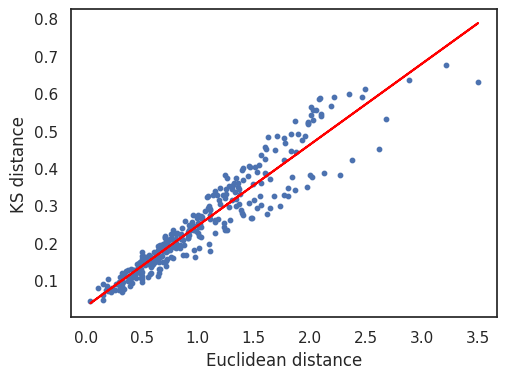

In [17]:
fig, ax = plt.subplots(figsize=(5.5,4))
ax.scatter(Edist, KSD, s=10.0)
dist = linregress(Edist, KSD)
ax.plot(Edist, dist.slope*Edist + dist.intercept, linestyle='-', color='red')
ax.set(xlabel='Euclidean distance', ylabel='KS distance')
#plt.savefig('KSdistance_Euclidean.pdf', bbox_inches="tight")

Two-dimensional ideological space, where the average opinions of the different ANES editions are linked by arrows (Supplementary Figure 10).

Text(0, 0.5, '$Y$')

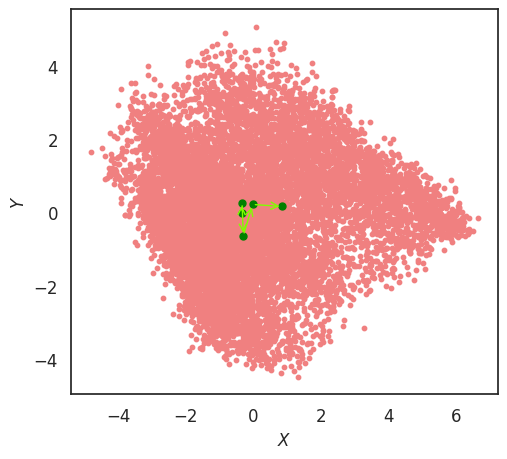

In [18]:
centerGlob = np.array([[0,0]])
for k in range(len(yearsSubset)):
    attributesYear = np.array([[0,0]])
    for sub in np.array(list(attributesData['party'][k].keys())):
        attributesYear = np.concatenate((attributesYear, attributesData['party'][k][sub]), axis=0)
    attributesYear = np.delete(attributesYear, 0, axis=0)
    center = meanPoints(attributesYear)
    centerGlob = np.concatenate((centerGlob, [np.array(center)]), axis=0)
centerGlob = np.delete(centerGlob, 0, axis=0)


fig, ax = plt.subplots(figsize = (5.5,5))

ax.scatter(points2d[:,0], points2d[:,1], s=10, color='lightcoral')
# Arrows
for k in range(len(yearsSubset)):
    plt.scatter(centerGlob[k,0], centerGlob[k,1], marker='.', c='green', s=100)
for k in range(len(yearsSubset) - 1):
    plt.annotate('', xy=centerGlob[k+1], xytext=centerGlob[k], 
                 arrowprops={'arrowstyle': '->', 'mutation_scale': 13, 'color': 'chartreuse'}, va='center')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$X$', fontsize=12)
plt.ylabel('$Y$', fontsize=12)
#plt.savefig('embedding_arrows.pdf', bbox_inches="tight")

Radius of gyration of the opinion distributions for each group and year (Supplementary Figure 12).

[Text(0, 0.5, '1992'),
 Text(0, 1.5, '2000'),
 Text(0, 2.5, '2008'),
 Text(0, 3.5, '2016'),
 Text(0, 4.5, '2020')]

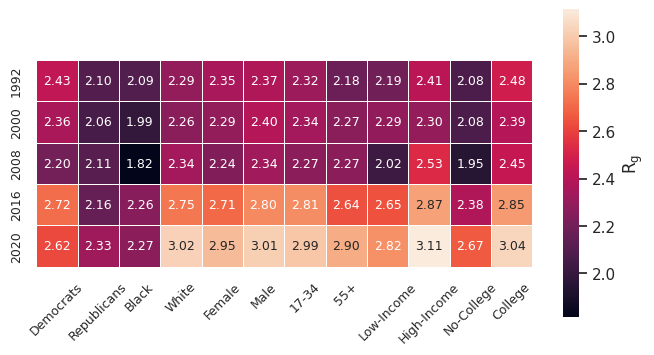

In [19]:
RgDic = dict()
for attr in attributes:
    for sub in subcats[attr]:
        Rg = np.array([])
        for k in range(len(yearsSubset)):
            subUsers = np.array(attributesData[attr][k][sub])
            x = subUsers[:,0]
            y = subUsers[:,1]
            Rg = np.append(Rg, np.sqrt(np.var(x) + np.var(y)))
        RgDic[sub] = Rg
RgData = pd.DataFrame(data=RgDic, index=yearsSubset)


fig, ax = plt.subplots(figsize=(8,8))
heat = sns.heatmap(RgData, annot=True, annot_kws={"size":9}, fmt=".2f", square=True, 
            linewidths=.5, cbar_kws={"shrink": .5, "label": r'$\mathregular{R_g}$'})
cbar = heat.collections[0].colorbar
cbar.ax.tick_params(labelsize=11)
heat.set_xticklabels(heat.get_xticklabels(), rotation=45)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
#plt.savefig('radius_gyration.pdf', bbox_inches="tight")

Density plots of Democrats and Republicans for the years 1992, 2000, 2008 and 2016, 2020 (Figure 6).

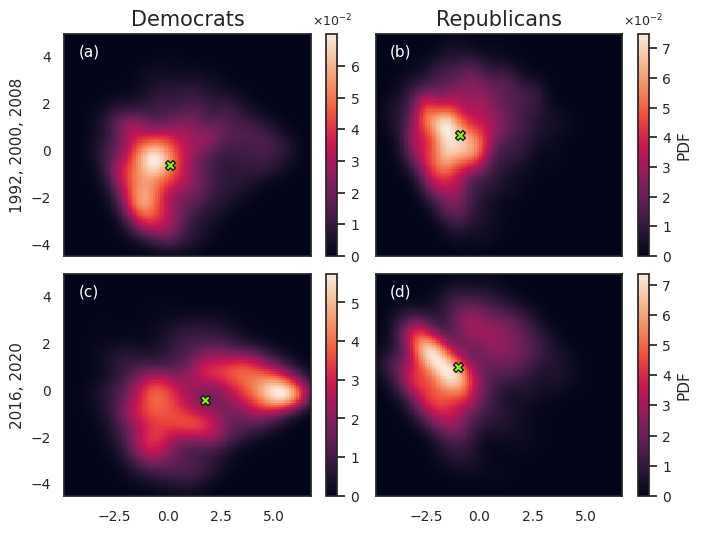

In [20]:
attr = 'party'
minYear = list()
maxYear = list()
kernels = dict()
centers = dict()
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,6))
fig.subplots_adjust(hspace=0.08)
fig.subplots_adjust(wspace=0.01)

# Plot limits
for sub in subcats[attr]:

    # Years 1992, 2000, 2008
    subUsers = np.array([[0,0]])
    for k in range(len(yearsSubset) - 2):
        subUsers = np.concatenate((subUsers, attributesData[attr][k][sub]), axis=0)
    subUsers = np.delete(subUsers, 0, axis=0)
    x1 = subUsers[:,0]
    minYear.append(x1.min())
    maxYear.append(x1.max())
    y1 = subUsers[:,1]
    minYear.append(y1.min())
    maxYear.append(y1.max())
    kernels[sub + '1'] = gaussian_kde([x1,y1])
    centers[sub + '1'] = meanPoints(subUsers)

    # Years 2016, 2020
    subUsers = np.array([[0,0]])
    for k in range(3,5):
        subUsers = np.concatenate((subUsers, attributesData[attr][k][sub]), axis=0)
    subUsers = np.delete(subUsers, 0, axis=0)
    x2 = subUsers[:,0]
    minYear.append(x2.min())
    maxYear.append(x2.max())
    y2 = subUsers[:,1]
    minYear.append(y2.min())
    maxYear.append(y2.max())
    kernels[sub + '2'] = gaussian_kde([x2,y2])
    centers[sub + '2'] = meanPoints(subUsers)

xmin, xmax = np.amin(minYear[::2]), np.amax(maxYear[::2])
ymin, ymax = np.amin(minYear[1::2]), np.amax(maxYear[1::2])
    

# Representation
nbins = 100
ticks = [[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05],
         [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]]
labels = [['0', '1', '2', '3', '4', '5', '6'], ['0', '1', '2', '3', '4', '5'],
         ['0', '1', '2', '3', '4', '5', '6', '7'], ['0', '1', '2', '3', '4', '5', '6', '7']]
annot = ['(a)', '(c)', '(b)', '(d)']
for n,sub in enumerate(subcats[attr]):
    
    xi, yi = np.mgrid[xmin:xmax:nbins*1j, ymin:ymax:nbins*1j]
    zi = kernels[sub + '1'](np.vstack([xi.flatten(), yi.flatten()]))

    im = ax[0,n].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
    ax[0,n].scatter(centers[sub + '1'][0], centers[sub + '1'][1], marker='X', c='chartreuse', ec='k', s=50)
    ax[0,n].tick_params(axis='y', labelsize=10)
    cbar = fig.colorbar(im, ax=ax[0,n], ticks=ticks[2*n])
    cbar.ax.set_yticklabels(labels[2*n])
    cbar.ax.tick_params(labelsize=10)
    if n == 1:
        cbar.ax.set_ylabel('PDF', fontsize=11)
    else:
        ax[0,n].set_ylabel('1992, 2000, 2008', fontsize=11)
    cbar.ax.set_title(r'$\mathregular{\times 10^{-2}}$', fontsize=9)
    ax[0,n].set_title(sub.capitalize(), fontsize=15)
    ax[0,n].annotate(annot[2*n], xy=(-4.2,4), color='w', fontsize=11)


    xi, yi = np.mgrid[xmin:xmax:nbins*1j, ymin:ymax:nbins*1j]
    zi = kernels[sub + '2'](np.vstack([xi.flatten(), yi.flatten()]))

    im = ax[1,n].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
    ax[1,n].scatter(centers[sub + '2'][0], centers[sub + '2'][1], marker='X', c='chartreuse', ec='k', s=50)
    ax[1,n].tick_params(axis='y', labelsize=10)
    ax[1,n].tick_params(axis='x', labelsize=10)
    cbar = fig.colorbar(im, ax=ax[1,n], ticks=ticks[2*n+1])
    cbar.ax.set_yticklabels(labels[2*n+1])
    cbar.ax.tick_params(labelsize=10)
    if n == 1:
        cbar.ax.set_ylabel('PDF', fontsize=11)
    else:
        ax[1,n].set_ylabel('2016, 2020', fontsize=11)
    ax[1,n].annotate(annot[2*n+1], xy=(-4.2,4), color='w', fontsize=11)
    
#plt.savefig('displacement_party.pdf', bbox_inches="tight")

## Proportions

Proportions of groups of the demographic attributes considered, over the years (Supplementary Figure 3).

Text(0, 0.5, 'Proportion between groups')

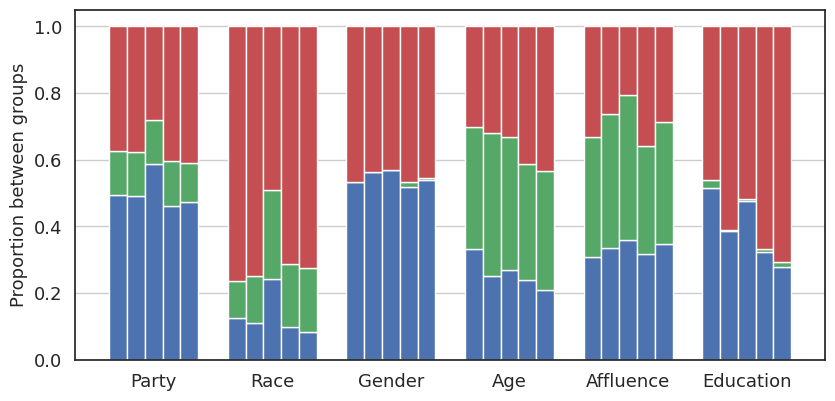

In [21]:
# Number of respondents per year
tot = np.zeros(len(yearsSubset))
for k in range(len(yearsSubset)):
    for sub in np.array(list(attributesData['party'][k].keys())):
        tot[k] += len(attributesData['party'][k][sub])

col_names = ["Year"] + [attr.capitalize() for attr in attributes]
ratio1, ratio2, other = list(), list(), list()
for i in range(len(yearsSubset)):
    ratio1.append([yearsSubset[i]])
    ratio2.append([yearsSubset[i]])
    other.append([yearsSubset[i]])
    for attr in attributes:
        num = list()
        # Ratio of respondents between groups
        for sub in subcats[attr]:
            points = attributesData[attr][i][sub]
            num.append(len(attributesData[attr][i][sub]))
        ratio1[i].append(num[0]/tot[i])
        ratio2[i].append(num[1]/tot[i])
        other[i].append(1.0 - (num[0] + num[1])/tot[i])


# Plotting proportions
fig = plt.figure(figsize=(7.5,3.5))
x = np.arange(len(col_names[1:]))
ax = fig.add_axes([0,0,1,1])

for i in range(len(yearsSubset)):
    ax.bar((x-0.3) + (i*0.75/len(yearsSubset)), ratio1[i][1:], color='b', width = 0.75/len(yearsSubset))
    ax.bar((x-0.3) + (i*0.75/len(yearsSubset)), other[i][1:], color='g', width = 0.75/len(yearsSubset), 
           bottom=ratio1[i][1:])
    ax.bar((x-0.3) + (i*0.75/len(yearsSubset)), ratio2[i][1:], color='r', width = 0.75/len(yearsSubset), 
           bottom = np.array(ratio1[i][1:]) + np.array(other[i][1:]))

ax.grid(axis='y')

ax.tick_params(axis='y', labelsize=13)
ax.set_xticks(x)
ax.set_xticklabels(col_names[1:], fontsize=13)
ax.set_ylabel("Proportion between groups", fontsize=13)
#plt.savefig('proportions_groups.pdf', bbox_inches="tight")

Opinion shift of Democrats between 1992, 2000, 2008 and 2016, 2020.

In [22]:
# Democratic respondents
attr, sub = 'party', 'Democrats'

subBefore = attributesData[attr][0][sub]
subBefore = np.concatenate((subBefore, attributesData[attr][1][sub]), axis=0)
subBefore = np.concatenate((subBefore, attributesData[attr][2][sub]), axis=0)

subAfter = attributesData[attr][3][sub]
subAfter = np.concatenate((subAfter, attributesData[attr][4][sub]), axis=0)


# 29 questions in total
questions = dfsCombined.iloc[:, :29].values
quesDic = {}
quesList = list(dfsCombined.columns[:-6])
for i in range(29):
    quesDic[i] = quesList[i]


# Questions before and after 2010
total = len(subAfter)
random.seed(9710)
subBefore = np.delete(subBefore, random.sample(range(len(subBefore)), len(subBefore) - total), axis=0)
quesBefore = []
quesAfter = []
for i in range(total):
    quesBefore.append(questions[np.where(points2d == subBefore[i,:])[0][0]])
    quesAfter.append(questions[np.where(points2d == subAfter[i,:])[0][0]])

quesBefore = np.array(quesBefore).T
quesAfter = np.array(quesAfter).T


# Largest difference between both periods
diff = np.array([np.sum(quesBefore, axis=1), np.sum(quesAfter, axis=1)])/total
great = np.argsort(np.abs(diff[0] - diff[1]))[::-1][:5]
for i in great:
    print(round(diff[0][i], 3), round(diff[1][i], 3), quesDic[i])

0.655 0.393 Blacks should not be favored
0.556 0.299 Blacks must try harder
0.676 0.905 Protection to homosexuals
0.628 0.4 Authority of the bible
0.75 0.531 Should be more emphasis on traditional values


Partisan alignment of racial and income groups across years.

In [23]:
# 1992, 2000, 2008
demUsers = attributesData['party'][0]['Democrats']
repUsers = attributesData['party'][0]['Republicans']
for k in range(1,3):
    demUsers = np.concatenate((demUsers, attributesData['party'][k]['Democrats']), axis=0)
    repUsers = np.concatenate((repUsers, attributesData['party'][k]['Republicans']), axis=0)
overlapDem = {}
overlapRep = {}
for attr in ['race', 'affluence']:
    for i in range(2):
        subUsers = attributesData[attr][0][subcats[attr][i]]
        for k in range(1,3):
            subUsers = np.concatenate((subUsers, attributesData[attr][k][subcats[attr][i]]), axis=0)
        # Democrats
        subDem = np.concatenate((demUsers, subUsers), axis=0)
        percentDem = len(subDem)
        subDem = [tuple(pos) for pos in subDem]
        subDem = set(subDem)
        percentDem = (percentDem - len(subDem))/len(demUsers)
        overlapDem[subcats[attr][i]] = round(percentDem, 2)
        # Republicans
        subRep = np.concatenate((repUsers, subUsers), axis=0)
        percentRep = len(subRep)
        subRep = [tuple(pos) for pos in subRep]
        subRep = set(subRep)
        percentRep = (percentRep - len(subRep))/len(repUsers)
        overlapRep[subcats[attr][i]] = round(percentRep, 2)

print('Democrats 1992, 2000, 2008')
print(overlapDem)
print('Republicans 1992, 2000, 2008')
print(overlapRep)

print('-')

# 2016, 2020
demUsers = np.concatenate((attributesData['party'][3]['Democrats'], attributesData['party'][4]['Democrats']), axis=0)
repUsers = np.concatenate((attributesData['party'][3]['Republicans'], attributesData['party'][4]['Republicans']), axis=0)
overlapDem = {}
overlapRep = {}
for attr in ['race', 'affluence']:
    for i in range(2):
        subUsers = np.concatenate((attributesData[attr][3][subcats[attr][i]], attributesData[attr][4][subcats[attr][i]]), axis=0)
        # Democrats
        subDem = np.concatenate((demUsers, subUsers), axis=0)
        percentDem = len(subDem)
        subDem = [tuple(pos) for pos in subDem]
        subDem = set(subDem)
        percentDem = (percentDem - len(subDem))/len(demUsers)
        overlapDem[subcats[attr][i]] = round(percentDem, 2)
        # Republicans
        subRep = np.concatenate((repUsers, subUsers), axis=0)
        percentRep = len(subRep)
        subRep = [tuple(pos) for pos in subRep]
        subRep = set(subRep)
        percentRep = (percentRep - len(subRep))/len(repUsers)
        overlapRep[subcats[attr][i]] = round(percentRep, 2)

print('Democrats 2016, 2020')
print(overlapDem)
print('Republicans 2016, 2020')
print(overlapRep)

Democrats 1992, 2000, 2008
{'Black': 0.26, 'White': 0.56, 'Low-Income': 0.38, 'High-Income': 0.23}
Republicans 1992, 2000, 2008
{'Black': 0.03, 'White': 0.84, 'Low-Income': 0.24, 'High-Income': 0.37}
-
Democrats 2016, 2020
{'Black': 0.16, 'White': 0.63, 'Low-Income': 0.36, 'High-Income': 0.32}
Republicans 2016, 2020
{'Black': 0.01, 'White': 0.85, 'Low-Income': 0.27, 'High-Income': 0.35}


## Seaborn figures

In [24]:
plt.style.use('seaborn-v0_8-dark')

Euclidean distance between opposite groups of the demographic attributes considered, over the years (Figure 3).

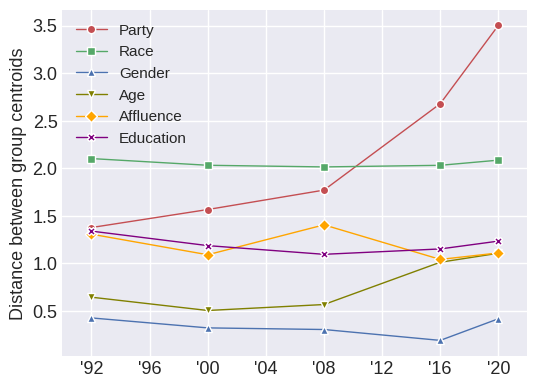

In [25]:
# Computing distances
distances = list()
for n,attr in enumerate(attributes):
    distances.append([attr])
    for i in range(len(yearsSubset)):
        coords = list()
        for sub in subcats[attr]:
            points = np.array(attributesData[attr][i][sub])
            coords.append(meanPoints(points))
        distances[n].append(math.dist(coords[0], coords[1]))

# Plotting distances
fig, ax = plt.subplots(figsize=(6,4.5))
ax.grid()
ax.set_xticks([1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020])
ax.set_xticklabels(['\'92', '\'96', '\'00', '\'04', '\'08', '\'12', '\'16', '\'20'], fontsize=13)
ax.set_xlim([1990, 2022])
ax.tick_params(axis='y', labelsize=13)
ax.set_ylabel("Distance between group centroids", fontsize=13)

colors = ['r','g','b', 'olive', 'orange', 'purple', 'darkkhaki', 'pink', 'skyblue']
markers=['o', 's', '^', 'v', 'D', 'X']
for n,attr in enumerate(attributes):
    plt.plot(yearsSubset, distances[n][1:], color=colors[n], label=attr.capitalize(), 
             marker=markers[n], markersize=6, linestyle='-', linewidth=1, 
             markeredgecolor='white', markeredgewidth=1)

ax.legend(loc='upper left', fontsize=11)
#plt.savefig('distances_attributes.pdf', bbox_inches="tight")

Centroids of groups of the most polarized attributes across years (Figure 4).

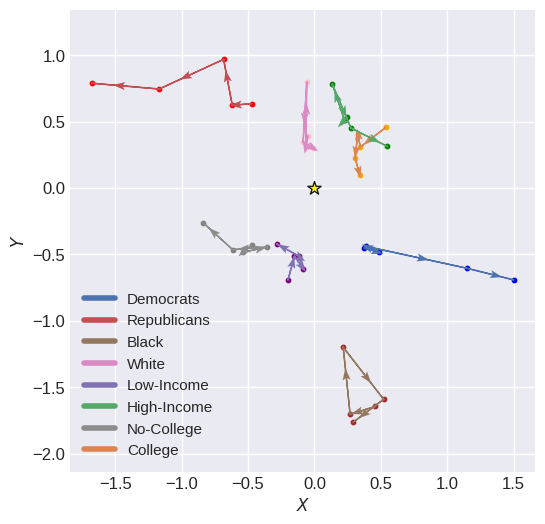

In [26]:
# Computing centroids
groups = ['Democrats', 'Republicans', 'Black', 'White', 'Low-Income', 'High-Income', 'No-College', 'College']
edco = ['blue', 'red', 'brown', 'pink', 'purple', 'green', 'gray', 'orange']
centroids = list()
plt.figure(figsize=(6,6))
for k in range(len(yearsSubset)):
    for i,attr in enumerate(attributesKS):
        for j,sub in enumerate(subcats[attr]):
            center = meanPoints(np.array(attributesData[attr][k][sub])) - centerGlob[k]
            plt.scatter(center[0], center[1], marker='.', c=edco[j + 2*i], s=40)
            centroids.append(center)

# Drawing arrows
colors = ['C0', 'C3', 'C5', 'C6', 'C4', 'C2', 'C7', 'C1']
items = len(yearsSubset) - 1
for k in range(items):
    for i,attr in enumerate(attributesKS):
        for j in range(len(subcats[attr])):
            c1 = centroids[2*k*items + j + 2*i]
            c2 = centroids[2*(k + 1)*items + j + 2*i]
            diff = c2 - c1
            plus = c2 + c1
            plt.arrow(c1[0], c1[1], diff[0], diff[1], color=colors[j + 2*i])
            plt.arrow(plus[0]/2, plus[1]/2, 0.01*diff[0], 0.01*diff[1], color=colors[j + 2*i], 
                      shape='full', lw=0, head_width=.06, overhang=0.2)

# Plotting centroids
plt.scatter(0, 0, marker='*', c='yellow', ec='k', s=100)
custom_lines = [Line2D([0], [0], color=colors[c], lw=4) for c in range(len(colors))]
plt.legend(custom_lines, groups, loc='lower left', fontsize=11)
plt.axis('equal')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$X$', fontsize=12)
plt.ylabel('$Y$', fontsize=12)
plt.grid()
#plt.savefig('centers_groups_arrows.pdf', bbox_inches="tight")

Euclidean distance of Democrats and Republicans from the center, over the years (Figure 5).

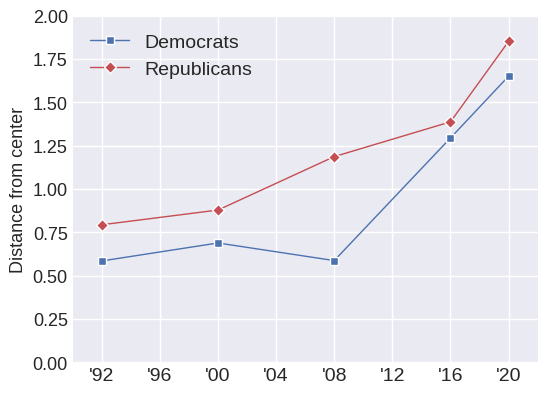

In [27]:
# Computing distances
attr = 'party'
dist = np.empty([len(yearsSubset), 2])
for k in range(len(yearsSubset)):
    for i,sub in enumerate(subcats[attr]):
        points = np.array(attributesData[attr][k][sub])
        center = meanPoints(points)
        dist[k,i] = math.dist(center, centerGlob[k])

# Plotting distances
fig, ax = plt.subplots(figsize=(6,4.5))
ax.grid()
ax.set_xticks([1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020])
ax.set_xticklabels(['\'92', '\'96', '\'00', '\'04', '\'08', '\'12', '\'16', '\'20'], fontsize=14)
ax.set_xlim([1990, 2022])
ax.set_ylim([0.0, 2.0])
ax.tick_params(axis='y', labelsize=13)
ax.set_ylabel("Distance from center", fontsize=13)

colors = ['b', 'r']
markers=['s', 'D']
for i in range(2):
    plt.plot(yearsSubset, dist[:,i], color=colors[i], label=subcats['party'][i], 
             marker=markers[i], markersize=6, linestyle='-', linewidth=1,
             markeredgecolor='white', markeredgewidth=1)

ax.legend(loc='upper left', fontsize=14)
#plt.savefig('distances_party.pdf', bbox_inches="tight")

## Null model

Null-hypothesis significance testing.

In [28]:
# Group names
col_names = list(["Year"])
for attr in attributes:
    for sub in subcats[attr]:
        col_names.append(sub)

        
start = time.time()

# Simulating random centroids
stat = list()
numOfIterations = 100000
for i in tqdm(range(len(yearsSubset))):
    stat.append([yearsSubset[i]])
    for attr in attributes:
        subs = subcats[attr]
        group1 = np.array(attributesData[attr][i][subs[0]])
        group2 = np.array(attributesData[attr][i][subs[1]])
        lenGroup1 = len(group1)
        lenGroup2 = len(group2)
        ratio = lenGroup1 / (lenGroup1 + lenGroup2)
        cg1 = meanPoints(group1)
        cg2 = meanPoints(group2)
        join = np.concatenate((group1,group2))
        threshold = int(len(join) * ratio) 
        centers1 = list() 
        centers2 = list()
        # Finding centroids by labelling at random, preserving ratio of respondents
        for _ in range(numOfIterations):
            np.random.shuffle(join)
            centers1.append(meanPoints(join[:threshold]))
            centers2.append(meanPoints(join[threshold:]))
        centers1 = np.array(centers1)
        centers2 = np.array(centers2)
        # Computing centroids of probability clouds
        probCloud1Center = meanPoints(centers1)
        probCloud2Center = meanPoints(centers2)
        
        # Computing p-value
        x1, y1 = centers1[:,0], centers1[:,1]
        x2, y2 = centers2[:,0], centers2[:,1]
        cov1 = np.mean(x1*y1) - np.mean(x1)*np.mean(y1)
        cov2 = np.mean(x2*y2) - np.mean(x2)*np.mean(y2)
        Rg1 = np.array([[np.var(x1), cov1], [cov1, np.var(y1)]])
        Rg2 = np.array([[np.var(x2), cov2], [cov2, np.var(y2)]])
        pval1 = np.exp(-0.5*(mahalanobis(np.array(cg1), np.array(probCloud1Center), inv(Rg1)))**2)
        pval2 = np.exp(-0.5*(mahalanobis(np.array(cg2), np.array(probCloud2Center), inv(Rg2)))**2)
        stat[i].append(f'{pval1:>.2e}') # p-value group1
        stat[i].append(f'{pval2:>.2e}') # p-value group2

end = time.time()


print('==========')
print(f"num_iterations: {numOfIterations}, execution_time: {round((end - start)/60., 2)} min")
print('==========')
print(tabulate(stat, headers=col_names))

100%|██████████████████████████████████████████| 5/5 [1:08:45<00:00, 825.14s/it]

num_iterations: 100000, execution_time: 68.76 min
  Year    Democrats    Republicans      Black      White    Female      Male     17-34       55+    Low-Income    High-Income    No-College    College
------  -----------  -------------  ---------  ---------  --------  --------  --------  --------  ------------  -------------  ------------  ---------
  1992    3.18e-81       3.18e-81   1.13e-100  1.13e-100  1.25e-08  1.25e-08  1.02e-14  1.02e-14      8.41e-56       8.41e-56      2.98e-78   2.98e-78
  2000    6.48e-76       6.48e-76   1.36e-67   1.36e-67   6.83e-05  6.83e-05  1.8e-05   1.8e-05       3.82e-28       3.82e-28      1.76e-47   1.76e-47
  2008    6.46e-113      6.46e-113  1.47e-118  1.47e-118  5.02e-05  5.02e-05  1.39e-10  1.39e-10      1.1e-47        1.1e-47       1.2e-56    1.2e-56
  2016    1.36e-195      1.36e-195  1.9e-72    1.9e-72    0.0159    0.0159    1.15e-19  1.15e-19      2.73e-36       2.73e-36      2.36e-44   2.36e-44
  2020    2.86e-242      2.86e-242  3.26e-74 